# Глубокое обучение в компьютерном зрении. Интерактивный курс
## Свёрточные нейронные сети (СНС)
### Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10  
### Библиотеки: [Python, Tensorflow]



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
x_train = x_train.reshape(-1, 32, 32, 3).astype('float32') / 255.
x_test = x_test.reshape(-1, 32, 32, 3).astype('float32') / 255.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [ ]:
y_train = y_train.flatten()
y_test = y_test.flatten()

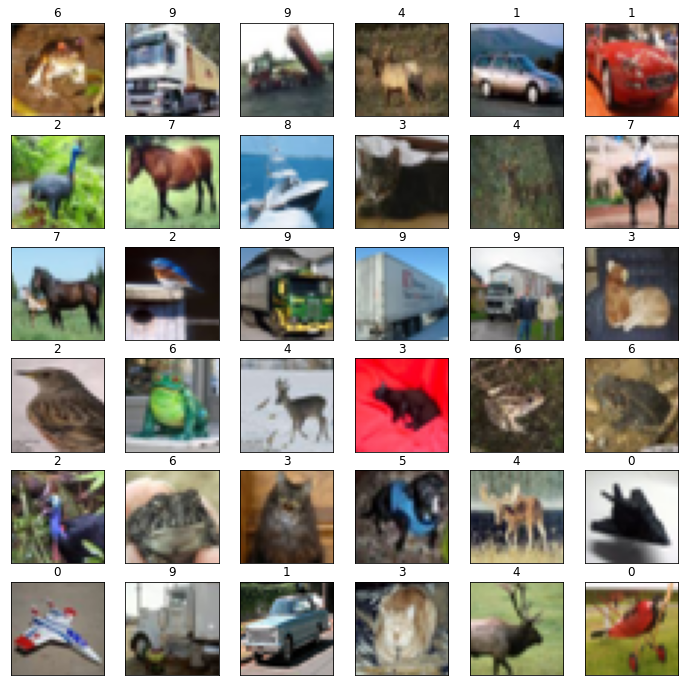

In [ ]:
some_samples = x_train[:36, ...]

fig = plt.figure(figsize=(12, 12))
for i in range(some_samples.shape[0]):
  ax = fig.add_subplot(6, 6, i+1)
  ax.imshow(some_samples[i, :, :, :], cmap='gray')
  plt.title(y_train[i])
  plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=x_train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [ ]:
class Model(tf.keras.Model):

  def __init__ (self):
    super(Model, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')
    self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')
    self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
    # self.conv4 = tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu')
    self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
    self.fs1 = tf.keras.layers.Dense(256, activation='relu')
    self.fs2 = tf.keras.layers.Dense(10, activation=None)
    self.flatten = tf.keras.layers.Flatten()

  def call(self, inp):

    out = self.conv1(inp)
    out = self.maxpool(out)
    out = self.conv2(out)
    out = self.maxpool(out)
    out = self.conv3(out)
    out = self.maxpool(out)
    # out = self.conv4(out)
    out = self.flatten(out)
    out = self.fs1(out)
    out = self.fs2(out)

    return out

model = Model()

In [ ]:
def loss(logits, labels):
  return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))


def accuracy(logits, labels):
  predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
  return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [ ]:
LEARNING_RATE = 0.001

optimazer = tf.keras.optimizers.Adam(LEARNING_RATE)

writer = tf.summary.create_file_writer('logs/adam')

In [ ]:
%%time

for iteration, (images, labels) in enumerate(train_ds):

  with tf.GradientTape() as tape:
    logits = model(images)
    loss_value = loss(logits, labels)


  grads = tape.gradient(loss_value, model.trainable_variables)
  optimazer.apply_gradients(zip(grads, model.trainable_variables))


  if iteration % 1000 == 0:
    test_logits = model(x_test[:256, ...])
    accuracy_value = accuracy(test_logits, y_test[:256, ...])

    print(f'{iteration}  Accuracy: {accuracy_value.numpy()*100:.2f}')

    with writer.as_default():
      tf.summary.scalar('accuracy', accuracy_value, iteration)
      tf.summary.scalar('loss', loss_value, iteration)

0  Accuracy: 10.16
1000  Accuracy: 61.72
2000  Accuracy: 71.09
3000  Accuracy: 72.27
4000  Accuracy: 70.70
5000  Accuracy: 72.27
6000  Accuracy: 77.73
7000  Accuracy: 73.83
CPU times: user 1h 8min 48s, sys: 1min 17s, total: 1h 10min 6s
Wall time: 40min 42s


In [ ]:
%%time

test_logits = model(x_test)
accuracy_value = accuracy(test_logits, y_test).numpy()
print(f'Final accuracy:  {accuracy_value*100:.2f}')

Final accuracy:  73.20
CPU times: user 20.1 s, sys: 2.06 s, total: 22.2 s
Wall time: 11.7 s


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

def test_item(sample):

  logits = model(sample[None, ...])[0] 
  prediction = tf.nn.softmax(logits)
  ans = np.argmax(prediction)

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1,2,1)
  ax.imshow(sample[:, :, 0], cmap='gray')
  plt.xticks([]), plt.yticks([])

  ax = fig.add_subplot(1, 2, 2)
  bar_list = ax.bar(np.arange(10), prediction, align='center')
  bar_list[ans].set_color('g')
  ax.set_xticks(np.arange(10))
  ax.set_xlim([-1, 10])
  ax.grid(True)
  plt.show()
  
  print(f'predicted: {ans}')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 239), started 0:00:16 ago. (Use '!kill 239' to kill it.)

<IPython.core.display.Javascript object>

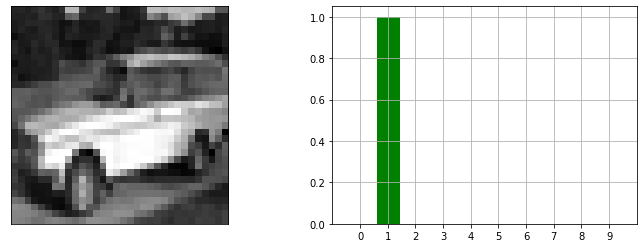

predicted: 1
True Answer: 1


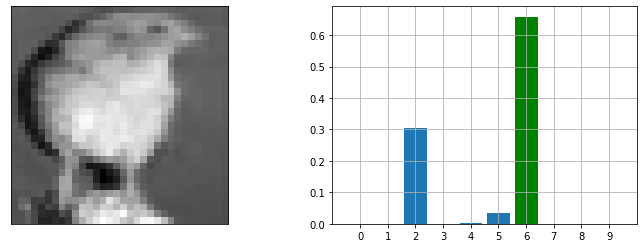

predicted: 6
True Answer: 2


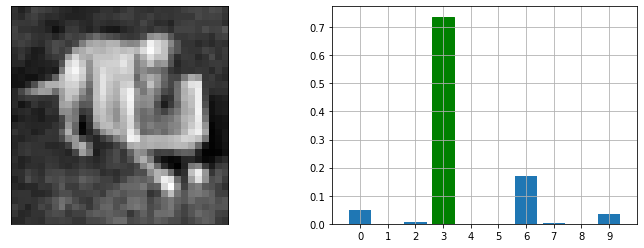

predicted: 3
True Answer: 5


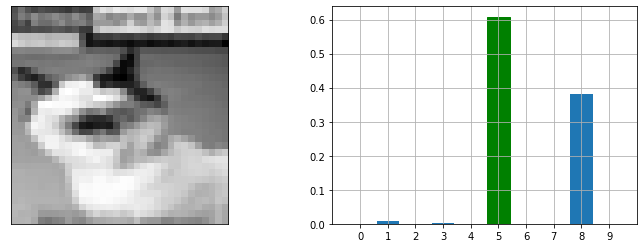

predicted: 5
True Answer: 3


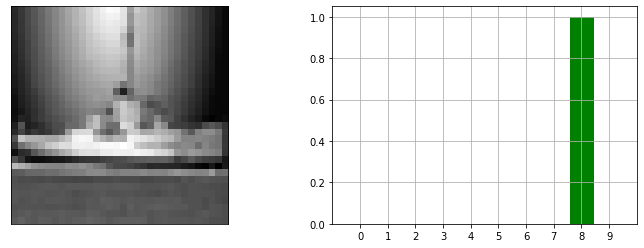

predicted: 8
True Answer: 8


In [ ]:
import random

for i in range(5):
  idx = random.randint(0, x_test.shape[0])
  sample = x_test[idx, ...]
  test_item(sample)

  print(f'True Answer: {y_test[idx]}')

In [ ]:
model2 = Model()

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=x_train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [ ]:
%%time

for iteration, (images, labels) in enumerate(train_ds):

  with tf.GradientTape() as tape:
    logits = model2(images)
    loss_value = loss(logits, labels)


  grads = tape.gradient(loss_value, model2.trainable_variables)
  optimazer.apply_gradients(zip(grads, model2.trainable_variables))


  if iteration % 1000 == 0:
    test_logits = model2(x_test[:256, ...])
    accuracy_value = accuracy(test_logits, y_test[:256, ...])

    print(f'{iteration}  Accuracy: {accuracy_value.numpy()*100:.2f}')

    with writer.as_default():
      tf.summary.scalar('accuracy', accuracy_value, iteration)
      tf.summary.scalar('loss', loss_value, iteration)

0  Accuracy: 9.38
1000  Accuracy: 51.95
2000  Accuracy: 57.03
3000  Accuracy: 59.77
CPU times: user 1h 6min 13s, sys: 1min 5s, total: 1h 7min 18s
Wall time: 38min 22s
